In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor


/Users/devaguru/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load the data


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Data loaded successfully!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Data loaded successfully!
Train shape: (10886, 12)
Test shape: (6493, 9)


# Datetime parsing & feature engineering



In [3]:
for df in [train, test]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofweek'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)  # weekend flag


# Select features and target

In [4]:
feature_cols = [
    'temp', 'humidity', 'windspeed',
    'hour', 'day', 'month', 'year',
    'dayofweek', 'weekend'
]
X = train[feature_cols]
y = train['count']


 # Log-transform the target

In [5]:
y_log = np.log1p(y)

# Train / validation split

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)


# Initialize & train the Random Forest

In [7]:
print("Training model with tuned parameters...")

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


Training model with tuned parameters...


RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

# Predict on validation set (log-space) and compute RMSLE

In [12]:
y_pred_log = model.predict(X_valid)
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(y_pred_log)))
print("Validation RMSLE:", rmsle)


Validation RMSLE: 0.3294886756169943


# Predict on test set and inverse-transform

In [9]:
test_X = test[feature_cols]
test_pred_log = model.predict(test_X)
#test['count'] = np.expm1(test_pred_log)
test['count'] = np.maximum(0, np.expm1(test_pred_log))


# Submission

In [10]:
submission = test[['datetime', 'count']]
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully: submission.csv")


Submission file created successfully: submission.csv


# Visualization

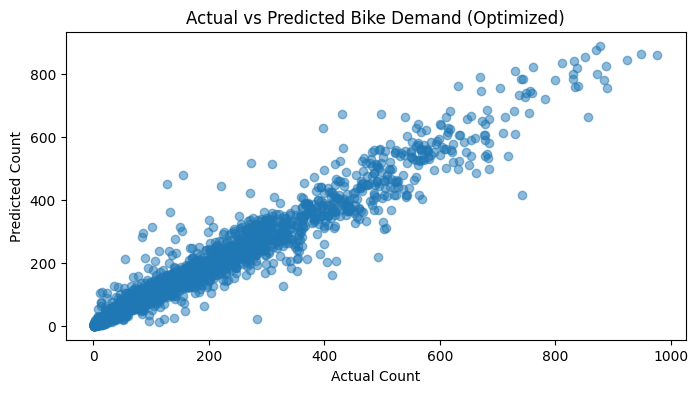

In [11]:
plt.figure(figsize=(8, 4))
plt.scatter(np.expm1(y_valid), np.expm1(y_pred_log), alpha=0.5)
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Bike Demand (Optimized)')
plt.show()